This notebook details the steps required to replicate the results discussed in [my blog post](https://paulminogue.com/) on analysing Arsenal's 03/04 team using network analysis.

The notebook will cover how I aquired the dataset and transformed it into the format required fore the analysis, the metrics I use to determine player influence, how we can these metrics, and how we can produce some sample network visuals using [NetworkX](https://networkx.github.io/).

Feel free to use this notebook to replicate my results, or as a basis for your own network analysis projects!

# Network analysis and centrality

## What is network analysis?

Network analysis can be thought of as a set of techniques which help us understand relationships and key entities within social structures.

While the network analysed in this blog post is based on passes between players in soccer matches, typical applications of network analysis include analysing Twitter to identify influential accounts and analysing the flow of money through a companies accounts as a way to identify potential fraudulent activity.

![alt text](images/example_network.png "A sample passing network")
*Figure 1: An example passing network containing 4 players*

## Centrality

In network analysis centrality is the term used to describe how important a node is within a network (high centrality implies a node is important).Centrality is often calculated by simply counting the number of links in and out of each node in the network (degree centrality), or by measuring a nodes importance in bridging gaps in the network (betweenness centrality).

While these centrality measures can in some cases be useful, they rely to0 heavily on the in and out degree of individual nodes and do not take into account each nodes relationship with other important nodes. For example, if we were to use a degree centrality measure in this analysis, it is entirely feasible that we could arrive at a conclusion where two defenders who constantly pass the ball back and forward to each other before playing it back to the goalkeeper are deemed to be the most influential passers on the team. This is where a centrality measure such as eigenvector centrality can be useful.

## Eigenvector centrality

Eigenvector centrality is models each node's influence based on its relationship to other important nodes within the network. This means that nodes which are connected to other high scoring nodes in the network will see their eigenvector centrality score increase, while those connected to nodes of lesser importance will see their scores decrease. This helps us overcome the problem mentioned above and helps us understand which nodes (or players in our case) have wide reaching influence on the pitch.

We can define the eigenvector centrality $x$ for a node $v$ as follows:

$$x_v = \frac{1}{\lambda} \sum_{t\in G} a_{v, t}x_t$$

Where $G$ represents the other nodes in the network, $a_{v, t}$ denotes the value in the adjacency matrix corresponding to nodes $v$ and $t$, $x_t$ represents the eigenvector centrality of node $t$, and $\lambda$ denotes the eigenvalue of the adjacency matrix.

As you can probably see, each nodes centrality score is dependant on the centrality score of the other nodes in the network. As such, the eigenvector centrality algorithm will run iteratively across each node in the network (typically initialising all nodes with a centrality score of 1) until each nodes converges upon its eigenvector centrality scores. At this point, the node with the highest score is deemed to be the most influential node in the network.

### What is an eigenvalue?

Of course, if you have never taken a linear algebra module you may be confused by idea of eigenvectors/eigenvalues. This is totally understandable (I've done linear algebra modules and I get confused too!), and while it is not strictly necessary to understand the algebra going on behind the scenes as python will look after all that, it may be of interest so let me explain it at a high level.

A non-zero vector $v$ is said to be an eigenvector of a matrix A if:

$$Av = \lambda v$$

Where $\lambda$ is a scaler, known as the eigenvalue.

Outside of network analysis, eigenvectors also have many other interesting applications in areas such as image processing and dimension reduction. If you are interested in learning more about how to calculate the eigenvectors of a matrix, I would recommend you check out the always useful [math is fun website](https://www.mathsisfun.com/algebra/eigenvalue.html#:~:text=One%20of%20the%20cool%20things,the%20scale%20of%20the%20stretch%3A&text=%E2%88%921%20means%20pointing%20backwards%20along%20the%20eigenvalue's%20direction).

### What is an adjacency matrix?

An adjacency matrix is a square matrix which maps the links between each node in our network. Each entry $A_{i, j}$ in the adjacency matrix the number of connections which exist between node $i$ and $j$ in the network. This should become clearer when we take a look the adjacency matrix for the network illustrated in figure 1.

$$ A = \begin{bmatrix} 0 & 1 & 1 & 1 \\ 1 & 0 & 1 & 0 \\ 1 & 1 & 0 & 0 \\ 1 & 0 & 0 & 0 \end{bmatrix}$$

Taking a look at the above we can see that player A's connections to player B, C , and D are captured across row 1 (and down column 1), player B's connection to A and C are in row 2, and so on.

# Identifying Arsenal's most influential invincibles

Now that we have a rough idea of what will be going on behind the scenes, we are ready to get stuck into the programming side of things!

In the following sections I will detail how we can acquire the data from GitHub and transform it into the format we require. From here I will show how we can use [NetworkX](https://networkx.github.io/) to identify the most influential players based on eigenvector centrality for both the season as a whole, and possessions which ended in a goal.

Some library imports and settings we should get out of the way before starting:

In [1]:
import json
import os
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from tqdm.notebook import tqdm

# plot settings
%matplotlib inline
plt.rcParams["figure.figsize"] = (20,12)
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False
plt.rcParams["axes.spines.bottom"] = False
plt.rcParams["axes.spines.left"] = False

## Acquiring the dataset

The dataset we will use for this tutorial will be the [StatsBomb](https://statsbomb.com/) open event dataset. This dataset contains match and event (passes, shots, etc.) data (in JSON) for 844 matches between 16-08-2003 and 23-02-2020. Luckily for us, 32 of these matches are from Arsenal's unbeaten 03/04 Premier League campaign.

Getting access to the data is very straightforward, you can simply clone the [StatsBomb open data repository](https://github.com/statsbomb/open-data) to your local machine.

`!git clone https://github.com/statsbomb/open-data.git`

Once downloaded, you will see all the data we need within the data subdirectory. You will also find a guide on how each of the match and event files relate to each other on the homepage of the repository.

If you want to follow along with this tutorial without having to change any of the paths, I would recommend cloning the repo into the same directory as the notebook (see below).

```
- network_analysis_tutorial.ipynb
- open-data/
    - data/
    - doc/
    - image/
    - README.md
    - LICENSE.pdf
```

## Process match data 

Once we have acquired the dataset, we can begin by creating a dataframe of all the match information available within the matches directory by iterating though each file, loading the match data within each file as a list of dictionaries, and extracting the required information from each match dictionary.

In [5]:
rootdir = 'open-data/data/matches'
# we will use this list to store our clean data and convert it to a dataframe
match_data_clean = []

# loop through each file in the matches directory
for subdir, dirs, files in os.walk(rootdir):
    for file in files:
        with open(os.path.join(subdir, file)) as json_file:
            # convert JSON to a list of dicts 
            matches = json.load(json_file)
            for match in matches:
                # extract the match info we may want and append to clean data list
                match_data_clean.append(
                    {
                        'match_id': match['match_id'],
                        'match_date': match['match_date'],
                        'competition': match['competition']['competition_name'],
                        'season': match['season']['season_name'],
                        'home_team': match['home_team']['home_team_name'],
                        'away_team': match['away_team']['away_team_name'],
                        'home_score': match['home_score'],
                        'away_score': match['away_score'],
                    }
                )
# convert to dataframe
match_df = pd.DataFrame(match_data_clean)

### Find Arsenal matches 

Once we have all the match data in a dataframe we can very easily filter this down to the Arsenal matches we will need for our analysis by filtering based on the home and away teams. 

In order to speed up the processing time on the event data later on, we can save the match id's for the arsenal matches to a list before continuing.

In [3]:
match_df.loc[(match_df['home_team']=='Arsenal') | (match_df['away_team']=='Arsenal')].sort_values(by='match_date')

,match_id,match_date,competition,season,home_team,away_team,home_score,away_score
826,3749493,2003-08-16,Premier League,2003/2004,Arsenal,Everton,2,1
819,3749358,2003-08-24,Premier League,2003/2004,Middlesbrough,Arsenal,0,4
823,3749454,2003-08-31,Premier League,2003/2004,Manchester City,Arsenal,1,2
817,3749296,2003-09-13,Premier League,2003/2004,Arsenal,Portsmouth,1,1
829,3749552,2003-09-21,Premier League,2003/2004,Manchester United,Arsenal,0,0
828,3749528,2003-09-26,Premier League,2003/2004,Arsenal,Newcastle United,3,2
818,3749253,2003-10-04,Premier League,2003/2004,Liverpool,Arsenal,1,2
813,3749079,2003-10-18,Premier League,2003/2004,Arsenal,Chelsea,2,1
824,3749526,2003-10-26,Premier League,2003/2004,Charlton Athletic,Arsenal,1,1
842,3749346,2003-11-01,Premier League,2003/2004,Leeds United,Arsenal,1,4


In [10]:
# create a list of arsenal matches so we can extract the events for these matches later
arsenal_matches  = list(
    match_df.loc[(match_df['home_team']=='Arsenal') | (match_df['away_team']=='Arsenal'), 'match_id']
)

## Process event data 

Similarly to how we loaded the match dataset, we can create a dataframe of passes and shots taken by the Arsenal team by iterating though each of the files and sub-directories in the events folder.

For each file (which represents a single match), we extract the match_id from the filename and compare it to the list of Arsenal match id's created above. If the event data relates to an Arsenal match, we go ahead and extract the shot and pass events for that match. For each pass event we will determine if it was a completed pass, and if so, who the passer and recipients were. For each shot event, we determine who shot the ball and what the result was (goal, saved, etc.). 

Finally we use the the match and possesion id's for goal events to determine which possesions ended in goals as we will use this later on when calculating the influence in goal possessions. To do this I simply filter the Arsenal events dataframe to goal events and join it back onto itself creating a `goal_possession` flag for each event in that possession.

In [11]:
event_data_dir = 'open-data/data/events'
events_data = []
for filename in os.listdir(event_data_dir):
    if filename.endswith(".json"): 
        with open(os.path.join(event_data_dir, filename)) as json_file:
            match_id = int(filename[:-5])
            # only process the data if its an arsenal match
            if match_id in arsenal_matches:
                data = json.load(json_file)
                for event in data:
                    # append the match id for each evemt
                    event['match_id'] = match_id
                    # determine if it is a pass or shot event and add it to our list
                    if event['type']['name'] in ['Pass', 'Shot'] and event['team']['name']=='Arsenal':
                        # need some logic for pass vs shot for some fields (easier to do outside the append)
                        if event['type']['name'] == 'Pass':
                                to = event['pass']['recipient']['name'] if event['pass'].get('recipient') else None
                                outcome = event['pass']['outcome']['name'] if event['pass'].get('outcome') else 'Complete'
                        else:
                                to = 'shot'
                                outcome = event['shot']['outcome']['name'] if event['shot'].get('outcome') else None
                        events_data.append(
                            {
                                'match_id': event['match_id'],
                                'possession_id':event['possession'],
                                'half':event['period'],
                                'timestamp': event['timestamp'],
                                'type':event['type']['name'],
                                'from': event['player']['name'],
                                'to': to,
                                'outcome': outcome
                            }
                        )
# convert to dataframe
events_df = pd.DataFrame(events_data)

# update the 'to' value to goal if the shot was scored
events_df.loc[events_df['outcome'] == 'Goal', 'to'] = 'Goal'

# figure our which possessions are part of a goal sequence, we will use this later on
goal_possessions = events_df.loc[events_df['outcome']=='Goal', ['match_id', 'possession_id']]
goal_possessions['goal_possession'] = True
events_df = events_df.merge(goal_possessions, how='left', on=['match_id', 'possession_id'])
events_df['goal_possession'] = events_df['goal_possession'].fillna(False)

print('Done')

Done


In [6]:
events_df.head()

,match_id,possession_id,half,timestamp,type,from,to,outcome,goal_possession
0,3749528,2,1,00:00:00.829,Pass,Sylvain Wiltord,Thierry Henry,Complete,False
1,3749528,2,1,00:00:02.140,Pass,Thierry Henry,Laureano Bisan-Etame Mayer,Complete,False
2,3749528,2,1,00:00:04.816,Pass,Laureano Bisan-Etame Mayer,Martin Keown,Complete,False
3,3749528,2,1,00:00:07.561,Pass,Martin Keown,Kolo Habib Touré,Complete,False
4,3749528,2,1,00:00:12.344,Pass,Kolo Habib Touré,Laureano Bisan-Etame Mayer,Complete,False


## Determine player influence

### Overall influence

To determine each players overall influence on the season we will calculate the eigenvector centrality based on that players completed and received passes over each game. From here we will calculate the mean centrality for each player, and the players with the highest mean eigenvector centrality over the 32 games in our dataset will be considered the most influential.

Of course since only up to 14 players (11 starters + a maximum of 3 substitutes) can play in each match it is commonplace for certain members of the squad not to get a game. We account for this by assigning any player that does not play in a given match an influence score of 0 for that match.

In terms of how we implement this in python (below) we begin filtering our events dataframe down to completed passes as we don't care about shots or goals for the moment.

From here we iterate though each match in our passing data and create a set of nodes based on the players who took part in the match (see `G.add_node()`).

Next we iterate through each event in the filtered match data and create a dictionary of from/to pairs (see `pair_frequencies`). This dictionary will track how often each player passed the ball to another player on the team. An example entry in this dictionary would be `{('Patrick Viera', 'Robert Pires): 10}`, which would capture the fact that Patrick Viera passed the ball to Robert Pires 10 times in the match.

Once we have our `pair_frequencies` dictionary created we can add edges to our graph by iterating through each pair in the `pair_frequencies` dictionary and using the `add_edge()` method.

From here we can easily calculate the eigenvector centrality using the `nx.eigenvector_centrality` function (note we specify the `weight` parameter to indicated we are using a weighted network) before converting it to a dataframe. We can very easily add more context to the centrality metrics by calculating the number of passes made and received by each player using a pandas aggregation before joining on the full player list and assigning any players who didn't take part in the match a centrality score of 0 for that match.

Finally we can once again use a pandas aggregation to determine each players mean centrality (as well as their in/out degree) for the season. 

Taking a look at the output, we can see that perhaps unsurprisingly, Robert Pires, Thierry Henry, and Patrick Viera were Arsenal's most influential players overall.

In [13]:
# lets just filter to completed passes
net_df = events_df.loc[events_df['outcome'] == 'Complete']

# get a list of players as a dataframe so we can account for instances where a player has no influence on the game
player_df = pd.DataFrame({'player':list(events_df['from'].drop_duplicates())})

# dataframe we will use to get each players centrallity for each match
centrality_df = pd.DataFrame()

matches = list(net_df['match_id'].drop_duplicates())

for match_id in matches:
    match_df = net_df.loc[net_df['match_id'] == match_id].copy()
    # initialise a weighted graph
    G = nx.DiGraph()
    # our nodes will be the players
    nodes = set(list(match_df['from']) + list(match_df['to']))
    for node in nodes:
        G.add_node(node)

    # create a dictionary of passing pair frequencies
    pair_frequencies = {}
    for index, row in match_df.iterrows():
        pass_pair = (row['from'], row['to'])
        if not pass_pair in pair_frequencies:
            pair_frequencies[pass_pair] = 1
        else:
            pair_frequencies[pass_pair] += 1

    # add edges to the graph
    for pair in pair_frequencies:
        G.add_edge(pair[0], pair[1], weight=pair_frequencies[pair] )
        
    # calculate eigenvector centrality and append
    match_centrality_df = pd.DataFrame(
        list(nx.eigenvector_centrality(G, weight="weight").items()),columns=['player', 'centrality']
    )
    
    # lets also calculate the in_degree and out_degree for some more context
    in_df = match_df.groupby('from')['match_id'].count().reset_index()
    in_df.columns = ['player', 'in_degree']
    out_df = match_df.groupby('to')['match_id'].count().reset_index()
    out_df.columns = ['player', 'out_degree']

    match_centrality_df = (
      match_centrality_df
      .merge(in_df, how='left', on='player')
      .merge(out_df, how='left', on='player')
    )
    
    # join to player df to account for players who were not involved
    match_centrality_df = player_df.merge(match_centrality_df, how='left', on='player')
    match_centrality_df['match_id'] = match_id
    match_centrality_df = match_centrality_df.fillna(0)
    
    centrality_df = pd.concat([centrality_df, match_centrality_df])
    
print("Done!")

# take a look at the results
centrality_df.groupby('player')[
    'centrality', 'in_degree', 'out_degree'
].mean().reset_index().sort_values(by='centrality', ascending=False)

Done!


<ipython-input-13-643190ec8f1b>:61: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  centrality_df.groupby('player')[


,player,centrality,in_degree,out_degree
16,Robert Pirès,0.342543,39.53125,43.56250
19,Thierry Henry,0.324581,22.81250,41.18750
14,Patrick Vieira,0.306374,40.90625,42.81250
5,Gilberto Aparecido da Silva,0.272891,34.78125,36.25000
10,Laureano Bisan-Etame Mayer,0.252448,42.53125,33.28125
0,Ashley Cole,0.240334,40.12500,31.93750
3,Fredrik Ljungberg,0.208163,20.09375,25.28125
1,Dennis Bergkamp,0.206137,19.75000,26.56250
9,Kolo Habib Touré,0.185615,33.21875,25.96875
2,Eduardo César Daude Gaspar,0.171017,22.15625,21.25000


### Influence in goal sequences 

The process for identifying the most influential players in goal sequences is essentially identical to the process described above. However since some goal sequences are too small to perform meaningful network analysis (contain 0 or 1 passes), we will simply combine all the goal sequences into one graph and calculate the eigenvector centrality using that graph.

To do this, we simply filter our events dataframe down to any possessions which finished in a goal being scored (`goal_possession == True`).

From here we create the nodes and edges in a similar fashion to above, before once again using the `nx.eigenvector_centrality` function to calculate each players centrality.

When we take a look at the goal sequences output we can see that Thierry Henry was the most influential player in Arsenal's goal sequences, followed by Robert Pires, Dennis Bergkamp, and Patrick Viera. These results make logical sense as anyone who watched Arsenal in 03/04 will be very familiar with the sight of Henry scoring a goal which was set up by Pires or Bergkamp.

In [14]:
# lets just filter to completed passes and goal sequences
goal_df = events_df.loc[
    (events_df['outcome'] == 'Complete') & (events_df['goal_possession'] == True)
].copy()

# initialise a weighted graph
G = nx.DiGraph()
# our nodes will be the players
nodes = set(list(goal_df['from']) + list(goal_df['to']))
for node in nodes:
    G.add_node(node)

# create a dictionary of passing pair frequencies
pair_frequencies = {}
for index, row in goal_df.iterrows():
    pass_pair = (row['from'], row['to'])
    if not pass_pair in pair_frequencies:
        pair_frequencies[pass_pair] = 1
    else:
        pair_frequencies[pass_pair] += 1

# add edges to the graph
for pair in pair_frequencies:
    G.add_edge(pair[0], pair[1], weight=pair_frequencies[pair] )

# calculate eigenvector centrality and append
centrality_df = pd.DataFrame(
    list(nx.eigenvector_centrality(G, weight="weight").items()),columns=['player', 'centrality']
)
centrality_df['centrality'] = round(centrality_df['centrality'], 4)

# lets also calculate the in_degree and out_degree
in_df = goal_df.groupby('from')['match_id'].count().reset_index()
in_df.columns = ['player', 'in_degreee']
out_df = goal_df.groupby('to')['match_id'].count().reset_index()
out_df.columns = ['player', 'out_degreee']

centrality_df = centrality_df.merge(in_df, how='left', on='player').merge(out_df, how='left', on='player')

# join to player df to account for players who were not involved
centrality_df = player_df.merge(centrality_df, how='left', on='player')
centrality_df = centrality_df.fillna(0)

print("Done!")

# take a look at the results
centrality_df.sort_values(by='centrality', ascending=False)

Done!


,player,centrality,in_degreee,out_degreee
1,Thierry Henry,0.4684,21,34.0
13,Robert Pirès,0.4432,33,33.0
14,Dennis Bergkamp,0.3746,26,27.0
7,Patrick Vieira,0.3689,26,27.0
8,Gilberto Aparecido da Silva,0.3049,26,28.0
10,Fredrik Ljungberg,0.2716,12,17.0
9,Ashley Cole,0.2582,22,19.0
11,Eduardo César Daude Gaspar,0.1585,13,12.0
2,Laureano Bisan-Etame Mayer,0.1246,20,11.0
4,Kolo Habib Touré,0.1061,11,8.0


## Creating visuals 

The blocks below provide examples of how we can very easily visualise networks using networkx and matplotlib. This can be useful when we want to explain the idea of network analysis to someone, or when performing some exploratory analysis on some new network data.

In the examples below I begin by creating a network for a single match (example 1) or a goal sequcne (example 2). Once the graph (`G`) is created we can plot the graph using the `draw_networkx_nodes()` and `draw_networkx_edges()` methods.

From here it is simply a case of repositioning the labels to provide a clearer view before displayin the graph using the standard `plt.show()` function.

### Example 1: A single match

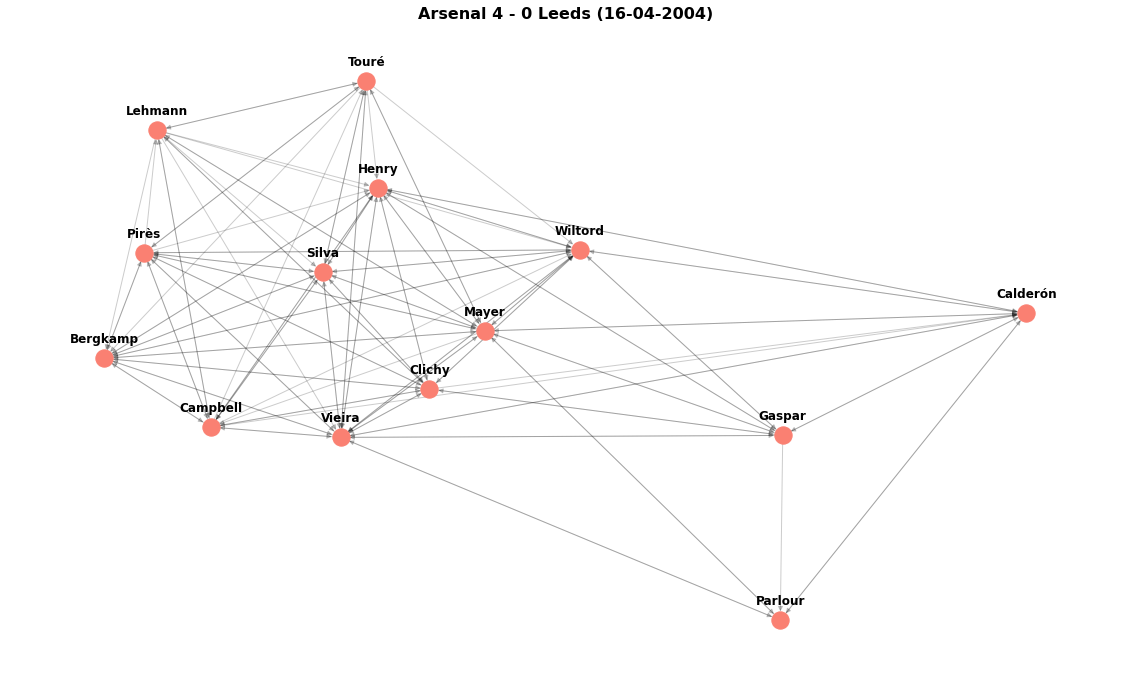

In [9]:
viz_df = events_df.loc[
    (events_df['outcome'] == 'Complete') &
    (events_df['match_id'] == 3749453)
]
# initialise a weighted graph
G = nx.DiGraph()

# our nodes will be the players
# im only interested in the players surnames here hence the use of split()[-1]
nodes = set(
    [name.split()[-1] for name in viz_df['from']] 
    + [name.split()[-1] for name in viz_df['to']] 
)
for node in nodes:
    G.add_node(node)

# create a dictionary of passing par frequencies
pair_frequencies = {}
for index, row in viz_df.iterrows():
    pass_pair = (row['from'].split()[-1], row['to'].split()[-1])
    if not pass_pair in pair_frequencies:
        pair_frequencies[pass_pair] = 1
    else:
        pair_frequencies[pass_pair] += 1

# add edges to the graph
for pair in pair_frequencies:
    G.add_edge(pair[0], pair[1], weight=pair_frequencies[pair])
    
# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='salmon')
nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.2)

# move labels outside of nodes to make it easier to read
label_pos = {}
for node, coords in pos.items():
    label_pos[node] = (coords[0], coords[1] + 0.05)
    
nx.draw_networkx_labels(G, label_pos, font_weight='bold')
plt.title("Arsenal 4 - 0 Leeds (16-04-2004)", fontsize=16, fontweight='bold')
plt.savefig('example_game_network.png')
plt.show()

### Example 2: A goal sequence

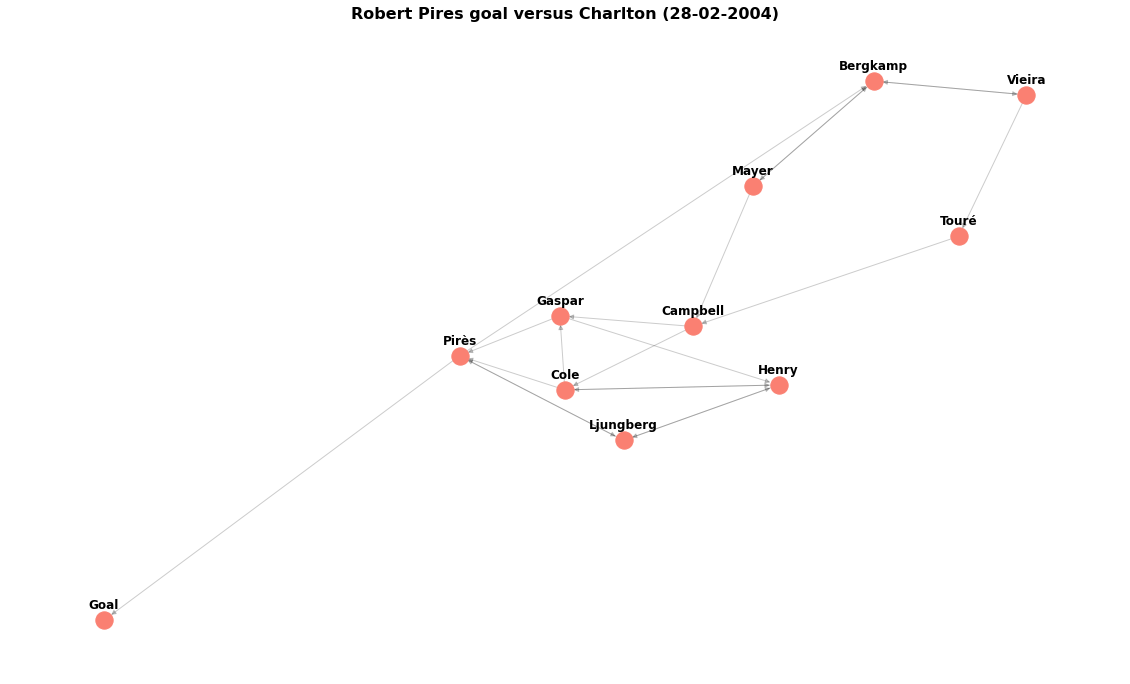

In [10]:
viz_df = events_df.loc[
    (events_df['outcome'].isin(['Complete', 'Goal'])) &
    (events_df['match_id'] == 3749642) &
    (events_df['possession_id'] == 5)
]
# initialise a weighted graph
G = nx.DiGraph()

# our nodes will be the players
# im only interested in the players surnames here hence the use of split()[-1]
nodes = set(
    [name.split()[-1] for name in viz_df['from']] 
    + [name.split()[-1] for name in viz_df['to']] 
)
for node in nodes:
    G.add_node(node)

# create a dictionary of passing par frequencies
pair_frequencies = {}
for index, row in viz_df.iterrows():
    pass_pair = (row['from'].split()[-1], row['to'].split()[-1])
    if not pass_pair in pair_frequencies:
        pair_frequencies[pass_pair] = 1
    else:
        pair_frequencies[pass_pair] += 1

# add edges to the graph
for pair in pair_frequencies:
    G.add_edge(pair[0], pair[1], weight=pair_frequencies[pair])
    
# Need to create a layout when doing
# separate calls to draw nodes and edges
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='salmon')
nx.draw_networkx_edges(G, pos, arrows=True, alpha=0.2)

# move labels outside of nodes to make it easier to read
label_pos = {}
for node, coords in pos.items():
    label_pos[node] = (coords[0], coords[1] + 0.05)
    
nx.draw_networkx_labels(G, label_pos, font_weight='bold')
plt.title("Robert Pires goal versus Charlton (28-02-2004)", fontsize=16, fontweight='bold')
plt.savefig('example_goal_network.png')
plt.show()